# Тестовое задание 

   Ваша задача написать пайплайн для тренировки модели глубоко обучения (любую – **embeddings + LSTM, Bert** …) с использованием следующих инструментов: pytorch, sklearn, matplotlib – для решения задачи **NER** (извлечения сущностей).

   В качестве данных используется датасет **Conll2003** с четырьмя классами **Per, Org, Loc, Misc** в формате **Conll**.

   В тетрадке ниже заданы основные классы и функции для построения требуемого пайплайн, какие-то уже имплементированы, какие-то – нет. Их требуется доработать. Тем не менее если данный набор абстракций вам не подходит Вы можете написать свой пайплайн «с нуля», однако обоснованность у этих действий должна быть.

**Что оценивается в первую очередь:**
- Выбранная архитектура для решения задачи
- Выбранные предобученные веса 
- Полученные метрики

**Затем:**
- Глубина разведочного анализа
- Какая схема теггирования используется (**BIO, IO** или другие)
- Каким образом производится расчет метрик (потокенный отчет, отчет по точному совпадению спанов сущностей)

**С меньшим приоритетом:** 
- Скорость предобработки и постобработки данных 
- Стиль кода

In [1]:
import itertools

import pandas as pd
import numpy as np



In [4]:
!wget https://raw.githubusercontent.com/synalp/NER/master/corpus/CoNLL-2003/eng.testa
!wget https://raw.githubusercontent.com/synalp/NER/master/corpus/CoNLL-2003/eng.train

--2021-05-24 13:14:15--  https://raw.githubusercontent.com/synalp/NER/master/corpus/CoNLL-2003/eng.testa
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 827012 (808K) [text/plain]
Saving to: ‘eng.testa’

eng.testa           100%[===================>] 807.63K  --.-KB/s    in 0.04s   

2021-05-24 13:14:15 (21.4 MB/s) - ‘eng.testa’ saved [827012/827012]

--2021-05-24 13:14:15--  https://raw.githubusercontent.com/synalp/NER/master/corpus/CoNLL-2003/eng.train
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3281528 (3.1M) [text/plain]
S

In [201]:
!head -10 eng.train 

-DOCSTART- -X- O O

EU NNP I-NP I-ORG
rejects VBZ I-VP O
German JJ I-NP I-MISC
call NN I-NP O
to TO I-VP O
boycott VB I-VP O
British JJ I-NP I-MISC
lamb NN I-NP O


In [31]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils import clip_grad_norm_
from typing import List
from collections import Counter
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch import nn
from sklearn.metrics import classification_report

In [ ]:
def read_data(file):
  lines = open(file, "r").readlines()
  data = {"sentences": [], "labels_per_sent": []}
  sentence, labels = [], []
  for line in tqdm(lines):
    line = line.strip()
    if not line:
      if sentence and labels:
        assert len(sentence) == len(labels)
        data["sentences"].append(sentence)
        data["labels_per_sent"].append(labels)
        sentence, labels = [], []
      continue
    if line.startswith("-DOCSTART-"):
      continue
    else:
      values = line.split(" ")
      try:
        token, _, _, label = values
        sentence.append(token)
        if label != 'O':
          labels.append(label.split('-')[-1])
        else:
          labels.append(label)

      except Exception as e:
        print(f"Error has occur: {e}")
        continue
  return data


train = read_data("eng.train")
valid = read_data("eng.testa")

100%|██████████| 55045/55045 [00:00<00:00, 867023.92it/s]


In [ ]:
train["sentences"][0], train["labels_per_sent"][0]

(['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.'],
 ['ORG', 'O', 'MISC', 'O', 'O', 'O', 'MISC', 'O', 'O'])

In [ ]:
valid["sentences"][0], valid["labels_per_sent"][0]

(['CRICKET',
  '-',
  'LEICESTERSHIRE',
  'TAKE',
  'OVER',
  'AT',
  'TOP',
  'AFTER',
  'INNINGS',
  'VICTORY',
  '.'],
 ['O', 'O', 'ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'])

In [ ]:
def get_label_distribution(labels: List[List[str]]):
  labels = [label for labels_per_sent in labels for label in labels_per_sent]
  return Counter(labels)

In [ ]:
train_distribution = get_label_distribution(train["labels_per_sent"])
valid_distribution = get_label_distribution(valid["labels_per_sent"])

Train distribution


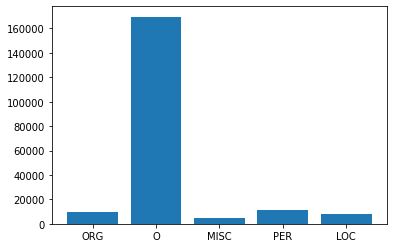

Valid distribution


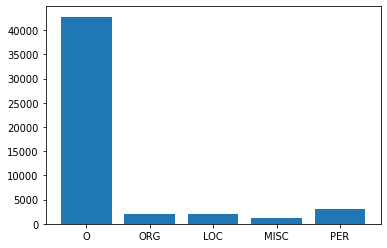

In [ ]:
def visualize_distr(data: Counter):
  labels = list(data.keys())
  plt.bar(x=labels, height=list(data.values()))
  plt.show()


print("Train distribution")
visualize_distr(train_distribution)
print("Valid distribution")
visualize_distr(valid_distribution)

### Посмотрев несколько хороших бенчмарков пришел к выводу, что для сравнительной характеристики (https://paperswithcode.com/sota/named-entity-recognition-ner-on-conll-2003) используют схему теггирования IOB1, поэтому будем использовать ее

In [25]:
def transform(name):
  df = pd.read_csv(name, sep=' ', comment='#')

  df = df.rename(columns={'-DOCSTART-':'token', 'O.1':'tag'})
  df['tag'] = df['tag'].astype('str')
  df = df[df['tag'] != 'nan']

  df['tag'] = [t.split('-')[1] if len(t) > 1 else 'O' for t in df['tag']]

  return df[['token', 'tag']]


In [26]:
train = transform('eng.train')
test = transform('eng.testa')
train.shape, test.shape

((202388, 2), (50937, 2))

### Поставим в соответствие определенному тэгу соответствующую метку и создадим метку PAD - паддинги

In [27]:
def build_dict(tokens_or_tags, special_tokens):
    """
    tokens_or_tags: a list of lists of tokens or tags
    special_tokens: some special tokens
    """
    # Create a dictionary with default value 0    
    # Create mappings from tokens to indices and vice versa
    # Add special tokens to dictionaries
    # The first special token must have index 0
    

    tokens = list(itertools.chain.from_iterable(tokens_or_tags))
    tokens.extend(special_tokens)
    tokens = list(set(tokens))
    tok2idx = dict(zip(tokens, list(range(len(tokens)))))
    idx2tok = dict(zip(list(range(len(tokens))), tokens))

    return tok2idx, idx2tok

In [28]:
train_token = [[i] for i in (list(train.token) + list(test.token))]
train_tags = [[i] for i in list(train.tag)]
test_token = [[i] for i in list(test.token)]
test_tags = [[i] for i in list(test.tag)]

special_tokens = ['<UNK>', '<PAD>']
special_tags = ["<PAD>"]

# Create dictionaries 
token2idx, idx2token = build_dict(train_token, special_tokens)
tag2idx, idx2tag = build_dict(train_tags, special_tags)

In [29]:
idx2tag

{0: 'ORG', 1: 'MISC', 2: '<PAD>', 3: 'O', 4: 'LOC', 5: 'PER'}

### Создание датасета и даталоадера

In [59]:
class NERDataset(Dataset):

  def __init__(self, tokens, tags, token2idx, tag2idx):
    tokens_idxs = [[token2idx[i] for i in j] for j in tokens]
    tags_idxs = [[tag2idx[i] for i in j] for j in tags]
    self.tokens_idxs = tokens_idxs
    self.tags_idxs = tags_idxs

  def __getitem__(self, index):
    return self.tokens_idxs[index], self.tags_idxs[index]

  def __len__(self):
    return len(self.tokens_idxs)

In [60]:
train_dataset = NERDataset(train_token[:train.shape[0]], train_tags[:train.shape[0]], token2idx, tag2idx)
valid_dataset = NERDataset(test_token, train_tags[:len(test_token)], token2idx, tag2idx)

In [61]:
def collate_fn(batch):
    # преобразовывает batch к нужному формату
    b_tokens, b_tags = zip(*batch) 
    lenghts = [len(i) for i in b_tags]
    max_len = max(lenghts)
    padded_b_tokens = [i + [token2idx["<PAD>"]]*(max_len - len(i)) for i in b_tokens]
    padded_b_tags = [i + [tag2idx["<PAD>"]]*(max_len - len(i)) for i in b_tags]
    x = torch.tensor(padded_b_tokens)
    y = torch.tensor(padded_b_tags)
    x = x.long()
    y = y.long()
    return x, y

In [62]:
bs = 32

train_datloader = DataLoader(train_dataset, batch_size=bs, shuffle=True, collate_fn=collate_fn)
valid_datloader = DataLoader(valid_dataset, batch_size=bs, shuffle=True, collate_fn=collate_fn)

## Будем использовать обыкновенную biLSTM модель

In [64]:
class NERModel(nn.Module):

  def __init__(self, vocabulary_size, n_tags, PAD_index,
                 embedding_dim, rnn_hidden_size,
                 dropout_zeroed_probability, bidirectional=True):
    super(NERModel, self).__init__()

    self.embeddings = nn.Embedding(vocabulary_size, embedding_dim)
    self.dropout = nn.Dropout(dropout_zeroed_probability)
    self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=rnn_hidden_size, 
                        bidirectional=bidirectional, batch_first=True)
    self.hidden2label = nn.Linear(rnn_hidden_size*(1 + int(bidirectional)), n_tags)

  def forward(self, x_batch):
    x = self.embeddings(x_batch)
    lstm_out, _ = self.lstm(x)
    drop_out = self.dropout(lstm_out)
    y = self.hidden2label(drop_out)
    return y.permute(0, 2, 1)

In [111]:
device = "cuda:0"
model = NERModel(len(token2idx), len(tag2idx), token2idx["<PAD>"], 
                    embedding_dim=100, rnn_hidden_size=100, 
                    dropout_zeroed_probability=.7).cuda()
model = model.to(device)

In [66]:
# необходим для обучения
class EmptyContext:
    def __enter__(self):
        pass
    def __exit__(self, type, value, traceback):
        pass

In [67]:
def perform_epoch(model, train_loader, valid_loader, criterion, 
                metric=None, optimizer=None, device=None, 
                scheduler=None, max_grad_norm=None):
    losses = []
    is_train = optimizer is not None
    model = model.to(device)
    if is_train:  
        model.train()
    else:
        model.eval()

    total_loss = 0
    total_acc = 0
    total_n = 0
    if is_train:
      pipeline = [[train_loader, True], [valid_loader, False]]  
    else:
      pipeline = [[train_loader, False]]  

    for loader, is_tr in pipeline:
      is_train = is_tr
      with EmptyContext() if is_train else torch.no_grad():
          for batch_train, batch_answers in loader:
              batch_train = batch_train.to(device)
              batch_answers = batch_answers.to(device)        
              model_answers = model(batch_train)
              new_loss = criterion(model_answers, batch_answers)
              if is_train:
                optimizer.zero_grad()
                new_loss.backward()
                
                if max_grad_norm is not None:
                  clip_grad_norm_(model.parameters(), max_grad_norm)
                optimizer.step() 
                if scheduler is not None:
                  scheduler.step()
              one_batch_loss = float(criterion(model_answers, batch_answers))
              total_loss += one_batch_loss

              if metric is not None:
                one_batch_metric = metric(model_answers, batch_answers)
                total_metric += one_batch_metric
              total_n += 1 
      if metric is not None:
          losses.append(total_loss / total_n, total_metric / total_n)
      else:
          losses.append(total_loss / total_n)
    return losses

In [113]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
max_grad_norm = 10.
lr = 1e-2
decay_rate =0.9
num_epoches = 150

In [114]:
loss_function = nn.CrossEntropyLoss(ignore_index=tag2idx["<PAD>"])
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, decay_rate)

# Training with biLSTM

# С использованием схемы теггирования IOB1

In [115]:
for epoch in range(num_epoches):
    train_loss, valid_loss = perform_epoch(model, train_datloader, valid_datloader,
                                           loss_function, optimizer=optimizer, device=device, 
                                           max_grad_norm=max_grad_norm)
    
    if epoch % 20 == 0:
        print(f"Start epoch #{epoch}")
        print(f"train loss {train_loss}")
        print(f"test loss {valid_loss}")
        print(f"Current learning rate: {optimizer.param_groups[0]['lr']}")
        print(f"End epoch #{epoch}")
    scheduler.step()

Start epoch #0
train loss 0.3949884207665979
test loss 0.6872048056577974
Current learning rate: 0.01
End epoch #0
Start epoch #20
train loss 0.06904154568605526
test loss 0.6110381716314469
Current learning rate: 0.001215766545905694
End epoch #20
Start epoch #40
train loss 0.06326711754898058
test loss 0.5740117455596772
Current learning rate: 0.00014780882941434616
End epoch #40
Start epoch #60
train loss 0.06258754194638666
test loss 0.5760617589057524
Current learning rate: 1.797010299914435e-05
End epoch #60
Start epoch #80
train loss 0.06205275864188519
test loss 0.5729187223433224
Current learning rate: 2.1847450052839273e-06
End epoch #80
Start epoch #100
train loss 0.06178293450598388
test loss 0.573702436475916
Current learning rate: 2.6561398887587566e-07
End epoch #100
Start epoch #120
train loss 0.062348402850449514
test loss 0.5742257101644818
Current learning rate: 3.2292460179985664e-08
End epoch #120
Start epoch #140
train loss 0.062130868273774315
test loss 0.5726027

In [116]:
def eval(model, loader, device=None):
    losses = []
    f1_scores = []
    is_train = optimizer is not None
    model = model.to(device)
    model.eval()
    predictions = []
    tags = []

    with torch.no_grad():
        for batch_train, batch_answers in loader:
            batch_train = batch_train.to(device)
            batch_answers = batch_answers.to(device)        
            model_answers = model(batch_train)
            predictions += torch.argmax(model_answers, axis=1)
            tags += batch_answers
    tags = [int(i) for i in tags]
    predictions = [int(i) for i in predictions]
    return tags, predictions

In [117]:
tags, predictions = eval(model, valid_datloader, device='cpu')

In [118]:
from sklearn.metrics import classification_report
target_names = ['ORG', 'MISC', 'O', 'LOC', 'PER']
print(classification_report(tags, predictions, target_names=target_names))

              precision    recall  f1-score   support

         ORG       0.04      0.05      0.05      2068
        MISC       0.03      0.03      0.03      1306
           O       0.82      0.82      0.82     41866
         LOC       0.05      0.04      0.05      2439
         PER       0.07      0.07      0.07      3258

    accuracy                           0.69     50937
   macro avg       0.20      0.20      0.20     50937
weighted avg       0.69      0.69      0.69     50937



# LUKE

### В качестве хорошего готового варианта можно использовать одно из лучших решений на бенчмарке CoNLL2003, основанное на трансформере - LUKE https://github.com/studio-ousia/luke (правда задействуется библиотека transformers)

In [37]:
!pip install seqeval git+https://github.com/huggingface/transformers.git

  Cloning https://github.com/huggingface/transformers.git to /tmp/pip-req-build-3m6x60sd
  Running command git clone -q https://github.com/huggingface/transformers.git /tmp/pip-req-build-3m6x60sd
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 51kB 4.5MB/s 
     |████████████████████████████████| 3.3MB 17.3MB/s 
     |████████████████████████████████| 901kB 49.5MB/s 
  Created wheel for transformers: filename=transformers-4.7.0.dev0-cp37-none-any.whl size=2308937 sha256=e8a50613efa769c1759e99b4cae03dbfe4206fda7f19184ef5f28be7e02c42e2
  Stored in directory: /tmp/pip-ephem-wheel-cache-nxbzmnaw/wheels/33/eb/3b/4bf5dd835e865e472d4fc0754f35ac0edb08fe852e8f21655f
Successfully built transformers
  Created wheel for seqeval: filename=seqeval-1.2.2-cp37-none-any.whl size=16172 sha256=dea906ea2ece398c2b830918d556e8a8f2cf4ca14c940618875ef5b14940933c
  Stored in directory: /root/.c

In [38]:
import unicodedata

import numpy as np
import seqeval.metrics
import spacy
import torch
from tqdm import tqdm, trange
from transformers import LukeTokenizer, LukeForEntitySpanClassification

In [39]:
# Load the model checkpoint
model = LukeForEntitySpanClassification.from_pretrained("studio-ousia/luke-large-finetuned-conll-2003")
model.eval()
model.to("cuda")

# Load the tokenizer
tokenizer = LukeTokenizer.from_pretrained("studio-ousia/luke-large-finetuned-conll-2003")

Some weights of the model checkpoint at studio-ousia/luke-large-finetuned-conll-2003 were not used when initializing LukeForEntitySpanClassification: ['luke.embeddings.position_ids']
- This IS expected if you are initializing LukeForEntitySpanClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LukeForEntitySpanClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
def load_documents(dataset_file):
    documents = []
    words = []
    labels = []
    sentence_boundaries = []
    with open(dataset_file) as f:
        for line in f:
            line = line.rstrip()
            if line.startswith("-DOCSTART"):
                if words:
                    documents.append(dict(
                        words=words,
                        labels=labels,
                        sentence_boundaries=sentence_boundaries
                    ))
                    words = []
                    labels = []
                    sentence_boundaries = []
                continue

            if not line:
                if not sentence_boundaries or len(words) != sentence_boundaries[-1]:
                    sentence_boundaries.append(len(words))
            else:
                items = line.split(" ")
                words.append(items[0])
                labels.append(items[-1])

    if words:
        documents.append(dict(
            words=words,
            labels=labels,
            sentence_boundaries=sentence_boundaries
        ))
        
    return documents


def load_examples(documents):
    examples = []
    max_token_length = 510
    max_mention_length = 30

    for document in tqdm(documents):
        words = document["words"]
        subword_lengths = [len(tokenizer.tokenize(w)) for w in words]
        total_subword_length = sum(subword_lengths)
        sentence_boundaries = document["sentence_boundaries"]

        for i in range(len(sentence_boundaries) - 1):
            sentence_start, sentence_end = sentence_boundaries[i:i+2]
            if total_subword_length <= max_token_length:
                # if the total sequence length of the document is shorter than the
                # maximum token length, we simply use all words to build the sequence
                context_start = 0
                context_end = len(words)
            else:
                # if the total sequence length is longer than the maximum length, we add
                # the surrounding words of the target sentence　to the sequence until it
                # reaches the maximum length
                context_start = sentence_start
                context_end = sentence_end
                cur_length = sum(subword_lengths[context_start:context_end])
                while True:
                    if context_start > 0:
                        if cur_length + subword_lengths[context_start - 1] <= max_token_length:
                            cur_length += subword_lengths[context_start - 1]
                            context_start -= 1
                        else:
                            break
                    if context_end < len(words):
                        if cur_length + subword_lengths[context_end] <= max_token_length:
                            cur_length += subword_lengths[context_end]
                            context_end += 1
                        else:
                            break

            text = ""
            for word in words[context_start:sentence_start]:
                if word[0] == "'" or (len(word) == 1 and is_punctuation(word)):
                    text = text.rstrip()
                text += word
                text += " "

            sentence_words = words[sentence_start:sentence_end]
            sentence_subword_lengths = subword_lengths[sentence_start:sentence_end]

            word_start_char_positions = []
            word_end_char_positions = []
            for word in sentence_words:
                if word[0] == "'" or (len(word) == 1 and is_punctuation(word)):
                    text = text.rstrip()
                word_start_char_positions.append(len(text))
                text += word
                word_end_char_positions.append(len(text))
                text += " "

            for word in words[sentence_end:context_end]:
                if word[0] == "'" or (len(word) == 1 and is_punctuation(word)):
                    text = text.rstrip()
                text += word
                text += " "
            text = text.rstrip()

            entity_spans = []
            original_word_spans = []
            for word_start in range(len(sentence_words)):
                for word_end in range(word_start, len(sentence_words)):
                    if sum(sentence_subword_lengths[word_start:word_end]) <= max_mention_length:
                        entity_spans.append(
                            (word_start_char_positions[word_start], word_end_char_positions[word_end])
                        )
                        original_word_spans.append(
                            (word_start, word_end + 1)
                        )

            examples.append(dict(
                text=text,
                words=sentence_words,
                entity_spans=entity_spans,
                original_word_spans=original_word_spans,
            ))

    return examples


def is_punctuation(char):
    cp = ord(char)
    if (cp >= 33 and cp <= 47) or (cp >= 58 and cp <= 64) or (cp >= 91 and cp <= 96) or (cp >= 123 and cp <= 126):
        return True
    cat = unicodedata.category(char)
    if cat.startswith("P"):
        return True
    return False

test_documents = load_documents("eng.testa")
test_examples = load_examples(test_documents)

In [53]:
batch_size = 2
all_logits = []

for batch_start_idx in trange(0, len(test_examples), batch_size):
    batch_examples = test_examples[batch_start_idx:batch_start_idx + batch_size]
    texts = [example["text"] for example in batch_examples]
    entity_spans = [example["entity_spans"] for example in batch_examples]

    inputs = tokenizer(texts, entity_spans=entity_spans, return_tensors="pt", padding=True)
    inputs = inputs.to("cuda")
    with torch.no_grad():
        outputs = model(**inputs)
    all_logits.extend(outputs.logits.tolist())

100%|██████████| 1625/1625 [12:10<00:00,  2.22it/s]


In [54]:
final_labels = [label for document in test_documents for label in document["labels"]]

final_predictions = []
for example_index, example in enumerate(test_examples):
    logits = all_logits[example_index]
    max_logits = np.max(logits, axis=1)
    max_indices = np.argmax(logits, axis=1)
    original_spans = example["original_word_spans"]
    predictions = []
    for logit, index, span in zip(max_logits, max_indices, original_spans):
        if index != 0:  # the span is not NIL
            predictions.append((logit, span, model.config.id2label[index]))

    # construct an IOB2 label sequence
    predicted_sequence = ["O"] * len(example["words"])
    for _, span, label in sorted(predictions, key=lambda o: o[0], reverse=True):
        if all([o == "O" for o in predicted_sequence[span[0] : span[1]]]):
            predicted_sequence[span[0]] = "B-" + label
            if span[1] - span[0] > 1:
                predicted_sequence[span[0] + 1 : span[1]] = ["I-" + label] * (span[1] - span[0] - 1)

    final_predictions += predicted_sequence

In [55]:
print(seqeval.metrics.classification_report([final_labels], [final_predictions], digits=4)) 

              precision    recall  f1-score   support

         LOC     0.9780    0.9727    0.9753      1830
        MISC     0.9157    0.9147    0.9152       914
         ORG     0.9532    0.9567    0.9550      1341
         PER     0.9826    0.9836    0.9831      1832

   micro avg     0.9641    0.9635    0.9638      5917
   macro avg     0.9574    0.9569    0.9571      5917
weighted avg     0.9642    0.9635    0.9638      5917

